In [1]:
import sys
import random
import math
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
from FFNN import FFNN, FFNN_REG

In [2]:
def read_mnist(file_name):
    
    data_set = []
    with open(file_name,'rt') as f:
        for line in f:
            line = line.replace('\n','')
            tokens = line.split(',')
            label = tokens[0]
            attribs = []
            for i in range(784):
                attribs.append(tokens[i+1])
            data_set.append([label,attribs])
    return(data_set)
        
def show_mnist(file_name,mode):
    
    data_set = read_mnist(file_name)
    for obs in range(len(data_set)):
        for idx in range(784):
            if mode == 'pixels':
                if data_set[obs][1][idx] == '0':
                    print(' ',end='')
                else:
                    print('*',end='')
            else:
                print('%4s ' % data_set[obs][1][idx],end='')
            if (idx % 28) == 27:
                print(' ')
        print('LABEL: %s' % data_set[obs][0],end='')
        print(' ')
                   
def read_insurability(file_name):
    
    count = 0
    data = []
    with open(file_name,'rt') as f:
        for line in f:
            if count > 0:
                line = line.replace('\n','')
                tokens = line.split(',')
                if len(line) > 10:
                    x1 = float(tokens[0])
                    x2 = float(tokens[1])
                    x3 = float(tokens[2])
                    if tokens[3] == 'Good':
                        cls = 0
                    elif tokens[3] == 'Neutral':
                        cls = 1
                    else:
                        cls = 2
                    data.append([[cls],[x1,x2,x3]])
            count = count + 1
    return(data)

## Question 1:

In [3]:
train = read_insurability('three_train.csv')
valid = read_insurability('three_valid.csv')
test = read_insurability('three_test.csv')

In [4]:
def data_preprocess_three(records):
    features = [item[1] for item in records]
    labels = [item[0][0] for item in records]
    
    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)
    features = torch.tensor(features, dtype=torch.float32)
    labels = torch.tensor(labels)
    return features, labels

In [5]:
features_train, labels_train = data_preprocess_three(train)
features_val, labels_val = data_preprocess_three(valid)
features_test, labels_test = data_preprocess_three(test)

In [6]:
train_dataset = TensorDataset(features_train, labels_train)
val_dataset = TensorDataset(features_val, labels_val)
test_dataset = TensorDataset(features_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [7]:
model = FFNN(3, 2, 3) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [8]:
num_epochs = 100  # Set the number of epochs
best_val_loss = float('inf')
y_predicted = []

# create lists to store average losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        # Forward pass
        logits = model(X_batch)

        # Compute loss
        loss = criterion(logits, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")
    
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            logits_val = model(X_val)
            loss_val = criterion(logits_val, y_val)
            total_val_loss += loss_val.item()
    
    
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")

    # Save the best model or implement early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

# Evaluate on Test Set
model.eval()
total_test_loss = 0
with torch.no_grad():
    for X_test, y_test in test_loader:
        logits_test = model(X_test)
        loss_test = criterion(logits_test, y_test)
        total_test_loss += loss_test.item()
        
        prob = model.softmax(logits_test)
        # Make the prediction:
        predicted_class = torch.argmax(prob, dim=1)
        predicted_class = predicted_class.tolist()

        y_predicted.append(predicted_class)
    
avg_test_loss = total_test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")

y_predicted = [item for sublist in y_predicted for item in sublist]

Epoch [1/100], Training Loss: 1.0734
Epoch [1/100], Validation Loss: 1.0812
Epoch [2/100], Training Loss: 1.0656
Epoch [2/100], Validation Loss: 1.0735
Epoch [3/100], Training Loss: 1.0581
Epoch [3/100], Validation Loss: 1.0642
Epoch [4/100], Training Loss: 1.0461
Epoch [4/100], Validation Loss: 1.0419
Epoch [5/100], Training Loss: 1.0231
Epoch [5/100], Validation Loss: 1.0040
Epoch [6/100], Training Loss: 0.9877
Epoch [6/100], Validation Loss: 0.9591
Epoch [7/100], Training Loss: 0.9408
Epoch [7/100], Validation Loss: 0.8960
Epoch [8/100], Training Loss: 0.8874
Epoch [8/100], Validation Loss: 0.8265
Epoch [9/100], Training Loss: 0.8315
Epoch [9/100], Validation Loss: 0.7594
Epoch [10/100], Training Loss: 0.7724
Epoch [10/100], Validation Loss: 0.6927
Epoch [11/100], Training Loss: 0.7114
Epoch [11/100], Validation Loss: 0.6356
Epoch [12/100], Training Loss: 0.6575
Epoch [12/100], Validation Loss: 0.5847
Epoch [13/100], Training Loss: 0.6107
Epoch [13/100], Validation Loss: 0.5285
Epoc

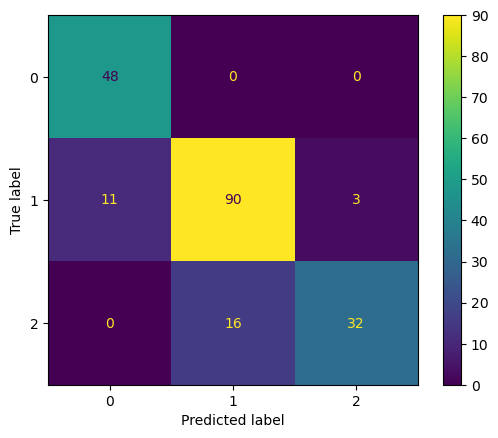

In [9]:
cm = confusion_matrix(labels_test, y_predicted)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [10]:
print(classification_report(labels_test, y_predicted))

              precision    recall  f1-score   support

           0       0.81      1.00      0.90        48
           1       0.85      0.87      0.86       104
           2       0.91      0.67      0.77        48

    accuracy                           0.85       200
   macro avg       0.86      0.84      0.84       200
weighted avg       0.86      0.85      0.85       200



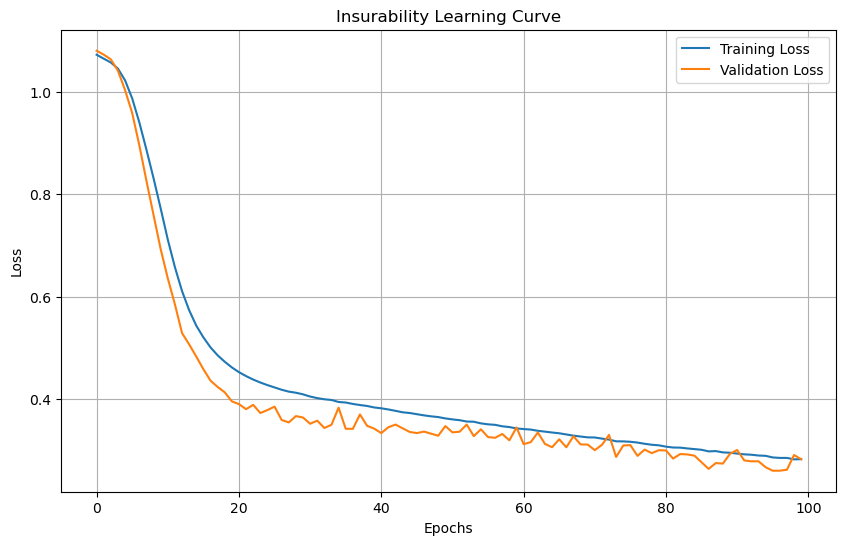

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Insurability Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Question 2:

In [12]:
train = read_mnist('mnist_train.csv')
valid = read_mnist('mnist_valid.csv')
test = read_mnist('mnist_test.csv')

In [13]:
def data_preprocess_mnist(records):
    features = [item[1] for item in records]
    labels = [item[0] for item in records]
    
    features = [[int(string) for string in item] for item in features]
    labels = [int(string) for string in labels]
    features = torch.tensor(features, dtype=torch.float32)
    labels = torch.tensor(labels)
    return features, labels

In [14]:
features_train, labels_train = data_preprocess_mnist(train)
features_val, labels_val = data_preprocess_mnist(valid)
features_test, labels_test = data_preprocess_mnist(test)

features_train /= 255.0
features_val /= 255.0
features_test /= 255.0

In [15]:
train_dataset = TensorDataset(features_train, labels_train)
val_dataset = TensorDataset(features_val, labels_val)
test_dataset = TensorDataset(features_test, labels_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
model = FFNN(784, 128, 10) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [17]:
num_epochs = 1000  # Set the number of epochs
#best_val_loss = float('inf')
y_predicted = []

# create lists to store average losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        # Forward pass
        logits = model(X_batch)

        # Compute loss
        loss = criterion(logits, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")
    
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            logits_val = model(X_val)
            loss_val = criterion(logits_val, y_val)
            total_val_loss += loss_val.item()
    
    
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")

    # Save the best model or implement early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

# Evaluate on Test Set
model.eval()
total_test_loss = 0
with torch.no_grad():
    for X_test, y_test in test_loader:
        logits_test = model(X_test)
        loss_test = criterion(logits_test, y_test)
        total_test_loss += loss_test.item()
        
        # add the softmax layer to predict the output
        prob = model.softmax(logits_test)
        # Make the prediction:
        predicted_class = torch.argmax(prob, dim=1)
        predicted_class = predicted_class.tolist()
        
        y_predicted.append(predicted_class)
    
avg_test_loss = total_test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")

y_predicted = [item for sublist in y_predicted for item in sublist]

Epoch [1/1000], Training Loss: 2.3088
Epoch [1/1000], Validation Loss: 2.2888
Epoch [2/1000], Training Loss: 2.2766
Epoch [2/1000], Validation Loss: 2.2802
Epoch [3/1000], Training Loss: 2.2608
Epoch [3/1000], Validation Loss: 2.2654
Epoch [4/1000], Training Loss: 2.2438
Epoch [4/1000], Validation Loss: 2.2557
Epoch [5/1000], Training Loss: 2.2283
Epoch [5/1000], Validation Loss: 2.2332
Epoch [6/1000], Training Loss: 2.2102
Epoch [6/1000], Validation Loss: 2.2211
Epoch [7/1000], Training Loss: 2.1909
Epoch [7/1000], Validation Loss: 2.2103
Epoch [8/1000], Training Loss: 2.1708
Epoch [8/1000], Validation Loss: 2.1855
Epoch [9/1000], Training Loss: 2.1480
Epoch [9/1000], Validation Loss: 2.1652
Epoch [10/1000], Training Loss: 2.1255
Epoch [10/1000], Validation Loss: 2.1429
Epoch [11/1000], Training Loss: 2.0987
Epoch [11/1000], Validation Loss: 2.1239
Epoch [12/1000], Training Loss: 2.0703
Epoch [12/1000], Validation Loss: 2.1018
Epoch [13/1000], Training Loss: 2.0403
Epoch [13/1000], Va

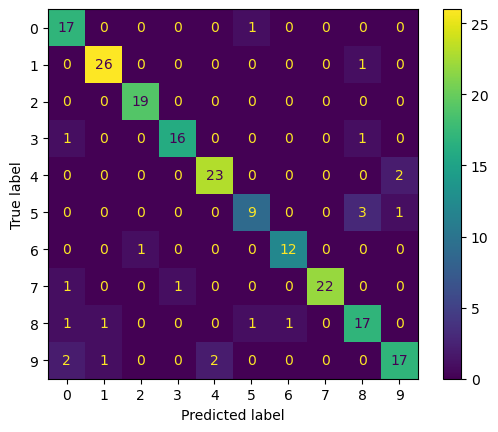

In [18]:
cm = confusion_matrix(labels_test, y_predicted)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [19]:
print(classification_report(labels_test, y_predicted))

              precision    recall  f1-score   support

           0       0.77      0.94      0.85        18
           1       0.93      0.96      0.95        27
           2       0.95      1.00      0.97        19
           3       0.94      0.89      0.91        18
           4       0.92      0.92      0.92        25
           5       0.82      0.69      0.75        13
           6       0.92      0.92      0.92        13
           7       1.00      0.92      0.96        24
           8       0.77      0.81      0.79        21
           9       0.85      0.77      0.81        22

    accuracy                           0.89       200
   macro avg       0.89      0.88      0.88       200
weighted avg       0.89      0.89      0.89       200



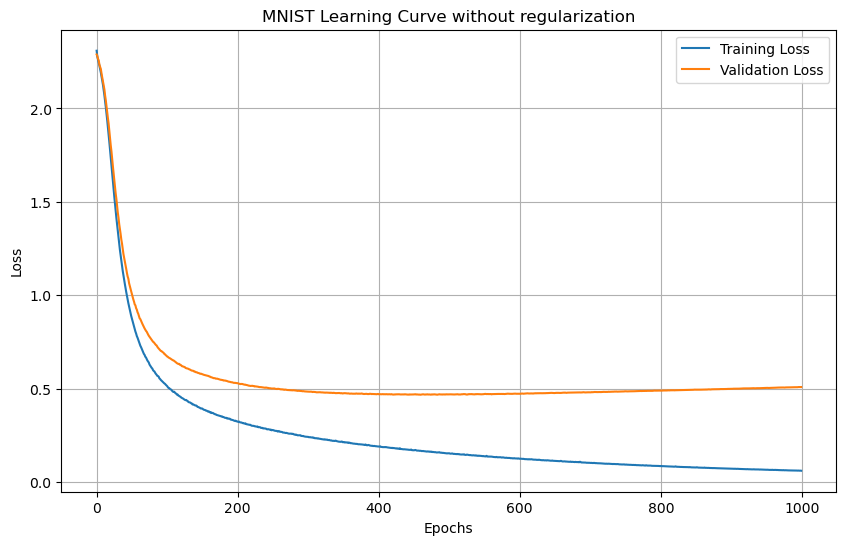

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('MNIST Learning Curve without regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Question 3:

In [21]:
model = FFNN_REG(784, 128, 10) 
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [22]:
num_epochs = 1000  # Set the number of epochs
y_predicted = []

# create lists to store average losses
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for X_batch, y_batch in train_loader:
        # Forward pass
        logits = model(X_batch)

        # Compute loss
        loss = criterion(logits, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")
    
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            logits_val = model(X_val)
            loss_val = criterion(logits_val, y_val)
            total_val_loss += loss_val.item()
    
    
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")

# Evaluate on Test Set
model.eval()
total_test_loss = 0
with torch.no_grad():
    for X_test, y_test in test_loader:
        logits_test = model(X_test)
        loss_test = criterion(logits_test, y_test)
        total_test_loss += loss_test.item()
        
        prob = model.softmax(logits_test)
        # Make the prediction:
        predicted_class = torch.argmax(prob, dim=1)
        predicted_class = predicted_class.tolist()
        
        y_predicted.append(predicted_class)
    
avg_test_loss = total_test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")

y_predicted = [item for sublist in y_predicted for item in sublist]

Epoch [1/1000], Training Loss: 2.3063
Epoch [1/1000], Validation Loss: 2.2947
Epoch [2/1000], Training Loss: 2.2806
Epoch [2/1000], Validation Loss: 2.2878
Epoch [3/1000], Training Loss: 2.2635
Epoch [3/1000], Validation Loss: 2.2697
Epoch [4/1000], Training Loss: 2.2474
Epoch [4/1000], Validation Loss: 2.2600
Epoch [5/1000], Training Loss: 2.2290
Epoch [5/1000], Validation Loss: 2.2433
Epoch [6/1000], Training Loss: 2.2108
Epoch [6/1000], Validation Loss: 2.2250
Epoch [7/1000], Training Loss: 2.1920
Epoch [7/1000], Validation Loss: 2.2118
Epoch [8/1000], Training Loss: 2.1713
Epoch [8/1000], Validation Loss: 2.1917
Epoch [9/1000], Training Loss: 2.1488
Epoch [9/1000], Validation Loss: 2.1741
Epoch [10/1000], Training Loss: 2.1250
Epoch [10/1000], Validation Loss: 2.1471
Epoch [11/1000], Training Loss: 2.0991
Epoch [11/1000], Validation Loss: 2.1295
Epoch [12/1000], Training Loss: 2.0718
Epoch [12/1000], Validation Loss: 2.1005
Epoch [13/1000], Training Loss: 2.0408
Epoch [13/1000], Va

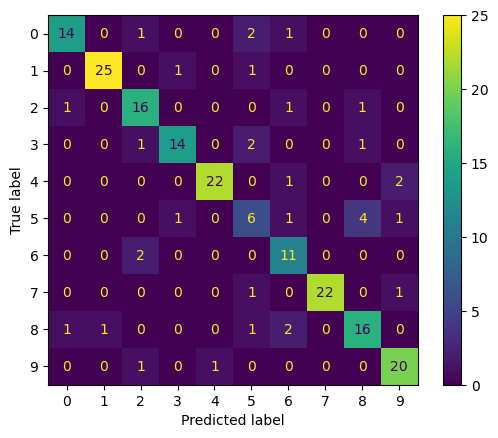

In [23]:
cm = confusion_matrix(labels_test, y_predicted)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [24]:
print(classification_report(labels_test, y_predicted))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82        18
           1       0.96      0.93      0.94        27
           2       0.76      0.84      0.80        19
           3       0.88      0.78      0.82        18
           4       0.96      0.88      0.92        25
           5       0.46      0.46      0.46        13
           6       0.65      0.85      0.73        13
           7       1.00      0.92      0.96        24
           8       0.73      0.76      0.74        21
           9       0.83      0.91      0.87        22

    accuracy                           0.83       200
   macro avg       0.81      0.81      0.81       200
weighted avg       0.84      0.83      0.83       200



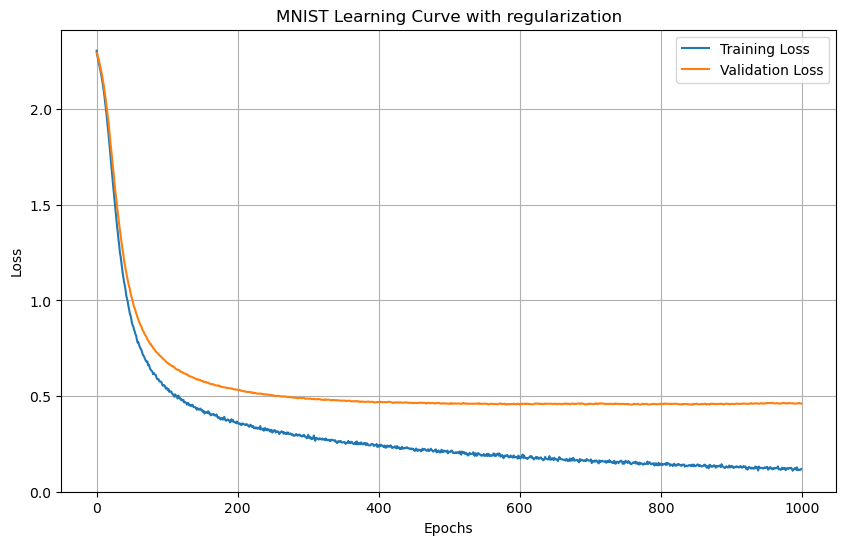

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('MNIST Learning Curve with regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()